In [234]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from numpy import linalg as LA

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
normalization = 255

In [3]:
def plot_J(J_history):
    x = np.arange(0, len(J_history))
    plt.plot(x, J_history)
    plt.show()

In [4]:
def normalize(X):
    return X / normalization

In [5]:
def denormalize(X):
    return X * normalization

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from mpmath import *
from sympy import *

In [7]:
class LogisticRegression():
    def __init__(self, normalize=True):
        self.normalize = normalize
        self.__mean = None
        self.__std = None
    
    def get_mean(self):
        return self.__mean
    
    def get_std(self):
        return self.__std
    
    def fit(self, X_vert, Y_vert, alpha, num_iters, epsilon):
        # X transformations
        if self.normalize == True:
            self.X_ = self.__normalize(X_vert)
        else:
            self.X_ = X_vert
        self.X_ = self.X_.T
 
        # Y transformations
        self.Y_ = Y_vert.T

        self.W = np.full(( self.X_.shape[0],self.Y_.shape[0]),0.01)
        self.b = 0.0
        self.W, self.b, self.Js = self.__gradient_descent(self.X_, self.Y_, self.W, self.b, alpha, num_iters, epsilon)

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)

        if self.normalize:
            X_norm = (X - self.__mean) / self.__std
            z = self.__stable_softmax(np.dot(self.W.T,X_norm.T)+self.b)
        else:
            z = self.__stable_softmax(np.dot(self.W.T,X.T)+self.b)
    
        y_pred = np.zeros(z.shape[1], dtype=int)
        for i in range(z.shape[1]):
            y_pred[i] = np.argmax(z[:, i])    
        
        return y_pred

    def predict_by_labels(self, X, y_labels):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        
        if self.normalize:
            X_norm = (X - self.__mean) / self.__std
            z = self.__stable_softmax(np.dot(self.W.T,X_norm.T)+self.b)
        else:
            z = self.__stable_softmax(np.dot(self.W.T,X.T)+self.b)
            
        y_pred = np.full((z.shape[1]), {})
        for i in range(z.shape[1]):
            y_pred[i] = { y_labels[j]: z[j][i] for j in range(z.shape[0])}
        return y_pred
            
    def get_cost_history(self):
        check_is_fitted(self)
        return self.Js

    def __normalize(self, X):
        if self.__mean is None and self.__std is None:
            mean = np.zeros([X.shape[1]])
            std  = np.ones([X.shape[1]])
            
            for i in range(X.shape[1]):
                if (np.std(X.iloc[:, i]) != 0):
                    mean[i] = np.mean(X.iloc[:, i])
                    std[i] = np.std(X.iloc[:, i])
            
            self.__mean = mean
            self.__std = std

        X_new = (X - self.__mean) / self.__std
        return X_new

    def __cost_function(self, X, Y, A):
        m = X.shape[0]
        if m == 0:
            return None
        
        J = (1 / m) * np.sum(-Y * np.log(A) - (1 - Y) * np.log(1 - A))
        return J

    def __cross_entropy(self, X, Y, A):
        m = X.shape[0]
        if m == 0:
            return None
        
        J = (-1 / m) * np.sum(Y.T * np.log(A.T))
        return J
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def __softmax(self, z):
        exps = np.exp(z)
        return exps / exps.sum(axis=0, keepdims=True)

    def __stable_softmax(self, z):
        exps = np.exp(z - np.max(z))
        return exps / exps.sum(axis=0, keepdims=True)

    def __forward_backward_propagation(self, X, Y, W, b):        
        # forward propagation
        m = X.shape[1]

        z = np.dot(W.T,X) + b
        A = self.__stable_softmax(z)
        cost = self.__cross_entropy(X, Y, A)

        # backward propagation
        dz = A - Y
        derivative_weights = (1 / m) * np.dot(X, dz.T)
        derivative_bias = (1 / m) * np.sum(dz)

        return cost, derivative_weights, derivative_bias

    def __gradient_descent(self, X, Y, W, b, alpha, num_iters, epsilon):        
        # num of samples
        m = X.shape[0]
        # num of features
        n = X.shape[1]

        J_history = []

        for i in range(num_iters):
            J, delta_weights, delta_bias = self.__forward_backward_propagation(X, Y, W, b)

            W = W - alpha * delta_weights
            b = b - alpha * delta_bias

            if i % 100 == 0:
                print(f"{i} iteration: {J}")

            J_history.append(J)

        return W, b, J_history

In [84]:
class AttackNoise():
    # Targeted Fast Gradient Sign Method Attack
    def attack(self, X_vert, Y_vert_true, predict_func, max_norm=1):
        self.max_norm = max_norm

        self.X_ = X_vert.T
        self.Y_ = np.expand_dims(Y_vert_true, axis=1)
        
        self.X_ = self.__add_noise(self.X_, self.Y_, predict_func)                
        return self.X_
   
    def __generate_noise(self, m, n):
        return np.random.uniform(low=-1, high=1, size=(m, n)) * self.max_norm

    def __is_tricked(self, X, Y, predict_func):
        # true class position
        true_class = np.argmax(Y[:, 0] != 0)

        if (predict_func(np.array(X))[0] == true_class):
            return False
        return True
    
    def __add_noise(self, X, Y, predict_func):
        # num of features
        m = X.shape[0]
        # num of samples
        n = X.shape[1]

        noise = self.__generate_noise(m, n);
        
        X = X + noise

        X[X > 1] = 1
        X[X < 0] = 0
                        
        if self.__is_tricked(X.T, Y, predict_func) == True:
            self.tricked = True
        else:
            self.tricked = False
        
        X_vert = X.T
        return X_vert

In [209]:
class AttackTIFGSM():
    # Targeted Iterative Fast Gradient Sign Method Attack
    def attack(self, X_vert, W, b, Y_vert_goal, predict_func, max_norm=1, max_iters=100):
        self.num_iters = 0
        self.max_iters = max_iters
        self.max_norm = max_norm
        
        self.W = W
        self.b = b

        self.Y_ = np.expand_dims(Y_vert_goal, axis=1)
        self.X_ = X_vert.T
        
        self.X_ = self.__gradient_descent(self.X_, self.Y_, self.W, self.b, predict_func)                
        return self.X_
            
    def __softmax(self, z):
        exps = np.exp(z)
        return exps / exps.sum(axis=0, keepdims=True)
        
    def __forward_backward_propagation(self, X, Y, W, b):
        m = X.shape[1]
        z = np.dot(W.T,X) + b
        A = self.__softmax(z)

        dz = A - Y
        derivative_x = np.dot(W, dz)
        return derivative_x

    def __is_tricked(self, X, Y, predict_func):
        goal_class = np.argmax(Y[:, 0] != 0)
        if (predict_func(np.array(X))[0] != goal_class):
            return False
        return True
    
    def __gradient_descent(self, X, Y, W, b, predict_func):        
        # num of features
        m = X.shape[0]
        # num of samples
        n = X.shape[1]
        
        alpha = self.max_norm / self.max_iters
        
        for i in range(self.max_iters):
            delta_x = self.__forward_backward_propagation(X, Y, W, b)
            X = X - alpha * np.sign(delta_x)
            X[X > 1] = 1
            X[X < 0] = 0

            self.num_iters += 1
                
            if self.__is_tricked(X.T, Y, predict_func) == True:
                self.tricked = True
                break
            else:
                self.tricked = False
        
        X_vert = X.T
        return X_vert

In [78]:
class AttackIFGSM():
    # Iterative Fast Gradient Sign Method Attack
    def attack(self, X_vert, W, b, Y_vert_true, predict_func, max_norm=1, max_iters=100):
        self.num_iters = 0
        self.max_iters = max_iters
        self.max_norm = max_norm
        
        self.W = W
        self.b = b

        self.Y_ = np.expand_dims(Y_vert_true, axis=1)
        self.X_ = X_vert.T
        
        self.X_ = self.__gradient_descent(self.X_, self.Y_, self.W, self.b, predict_func)                
        return self.X_
    
    def __softmax(self, z):
        exps = np.exp(z)
        return exps / exps.sum(axis=0, keepdims=True)
   
    def __softmax_bigfloat(self, z):
        z = np.array(z, dtype=Float)
        exps = Float(np.e) ** z
        return exps / exps.sum(axis=0, keepdims=True)
    
    def __forward_backward_propagation(self, X, Y, W, b):
        m = X.shape[1]
        z = np.dot(W.T,X) + b
        A = self.__softmax(z)
        
        dz = A - Y
        derivative_x = np.dot(W, dz)
        return np.array(derivative_x, dtype=float)

    def __is_tricked(self, X, Y, predict_func):
        true_class = np.argmax(Y[:, 0] != 0)
        if (predict_func(np.array(X))[0] == true_class):
            return False
        return True

    def __gradient_descent(self, X, Y, W, b, predict_func):        
        # num of features
        m = X.shape[0]
        # num of samples
        n = X.shape[1]
        
        alpha = self.max_norm / self.max_iters
        
        for i in range(self.max_iters):
            delta_x = self.__forward_backward_propagation(X, Y, W, b)
            X = X + alpha * np.sign(delta_x)
            X[X > 1] = 1
            X[X < 0] = 0
            
            self.num_iters += 1
                
            if self.__is_tricked(X.T, Y, predict_func) == True:
                self.tricked = True
                break
            else:
                self.tricked = False
                
        X_vert = X.T
        return X_vert

In [239]:
class AttackMIFGSM():
    # Iterative Fast Gradient Sign Method Attack
    def attack(self, X_vert, W, b, Y_vert_true, predict_func, max_norm=1, max_iters=100):
        self.num_iters = 0
        self.max_iters = max_iters
        self.max_norm = max_norm
        
        self.W = W
        self.b = b

        self.Y_ = np.expand_dims(Y_vert_true, axis=1)
        self.X_ = X_vert.T
        
        self.X_ = self.__gradient_descent(self.X_, self.Y_, self.W, self.b, predict_func)                
        return self.X_
    
    def __softmax(self, z):
        exps = np.exp(z)
        return exps / exps.sum(axis=0, keepdims=True)
   
    def __softmax_bigfloat(self, z):
        z = np.array(z, dtype=Float)
        exps = Float(np.e) ** z
        return exps / exps.sum(axis=0, keepdims=True)
    
    def __forward_backward_propagation(self, X, Y, W, b):
        m = X.shape[1]
        z = np.dot(W.T,X) + b
        A = self.__softmax(z)
        
        dz = A - Y
        derivative_x = np.dot(W, dz)
        return np.array(derivative_x, dtype=float)

    def __is_tricked(self, X, Y, predict_func):
        true_class = np.argmax(Y[:, 0] != 0)
        if (predict_func(np.array(X))[0] == true_class):
            return False
        return True

    def __gradient_descent(self, X, Y, W, b, predict_func):        
        # num of features
        m = X.shape[0]
        # num of samples
        n = X.shape[1]
        
        alpha = self.max_norm / self.max_iters
        g0 = 0
        u = 0.5
        
        for i in range(self.max_iters):
            delta_x = self.__forward_backward_propagation(X, Y, W, b)
            g1 = u * g0 + delta_x / LA.norm(delta_x, 1)          
            X = X + alpha * np.sign(g1)
            g0 = g1

            X[X > 1] = 1
            X[X < 0] = 0
            
            self.num_iters += 1
                
            if self.__is_tricked(X.T, Y, predict_func) == True:
                self.tricked = True
                break
            else:
                self.tricked = False
                
        X_vert = X.T
        return X_vert

In [79]:
class AttackFGSM():
    # Iterative Fast Gradient Sign Method Attack
    def attack(self, X_vert, W, b, Y_vert_true, predict_func, max_norm=1):
        self.max_norm = max_norm
        
        self.W = W
        self.b = b

        self.Y_ = np.expand_dims(Y_vert_true, axis=1)
        self.X_ = X_vert.T
        
        self.X_ = self.__gradient_descent(self.X_, self.Y_, self.W, self.b, predict_func)                
        return self.X_
    
    def __softmax(self, z):
        exps = np.exp(z)
        return exps / exps.sum(axis=0, keepdims=True)
    
    def __stable_softmax(self, z):
        exps = np.exp(z - np.max(z))
        return exps / exps.sum(axis=0, keepdims=True)
        
    def __forward_backward_propagation(self, X, Y, W, b):
        # forward propagation
        m = X.shape[1]
        z = np.dot(W.T,X) + b
        A = self.__softmax(z)
        
        # backward propagation
        dz = A - Y
        derivative_x = np.dot(W, dz)
        return np.array(derivative_x, dtype=float)

    def __is_tricked(self, X, Y, predict_func):
        # goal class position
        true_class = np.argmax(Y[:, 0] != 0)
        if (predict_func(np.array(X))[0] == true_class):
            return False
        return True

    def __gradient_descent(self, X, Y, W, b, predict_func):     
        m = X.shape[0]
        n = X.shape[1]
        
        delta_x = self.__forward_backward_propagation(X, Y, W, b)
        X = X + self.max_norm * np.sign(delta_x)
            
        X[X > 1] = 1
        X[X < 0] = 0

        if self.__is_tricked(X.T, Y, predict_func) == True:
            self.tricked = True
        else:
            self.tricked = False
        
        X_vert = X.T
        return X_vert

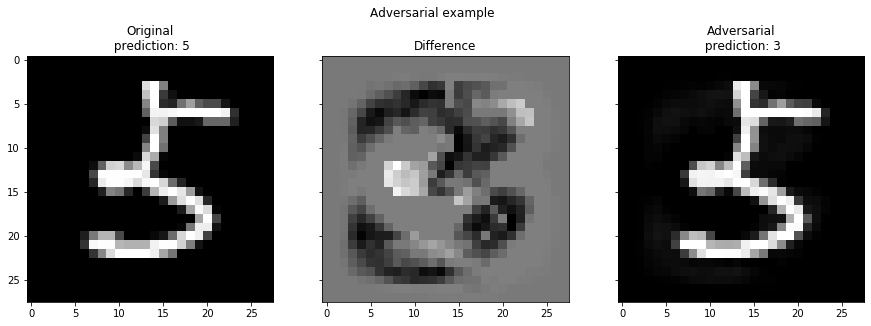

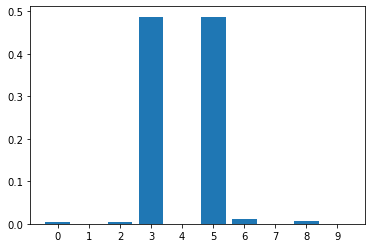

Perturbation: 12.583484850548912; Result: True
Max value: 255.0
Min value: 0.0
Max perturbation: 19.93078616404803


In [193]:
class AttackDeepFool():
    # Deep Fool Attack
    def attack(self, X_vert, W, b, Y_vert_true, predict_func, max_norm=1, max_iters=100):
        self.num_iters = 0
        self.max_iters = max_iters
        self.max_norm = max_norm
        
        self.W = W
        self.b = b

        self.Y_ = np.expand_dims(Y_vert_true, axis=1)
        self.X_ = X_vert.T
        
        self.X_ = self.__deep_fool(self.X_, self.Y_, self.W, self.b, predict_func)                
        return self.X_
    
    def __stable_softmax(self, z):
        exps = np.exp(z - np.max(z))
        return exps / exps.sum(axis=0, keepdims=True)
        
    def __softmax(self, z):
        exps = np.exp(z)
        return exps / exps.sum(axis=0, keepdims=True)

    def __is_tricked(self, X, Y, predict_func):
        true_class = np.argmax(Y[:, 0] != 0)
        if (predict_func(np.array(X))[0] == true_class):
            return False
        return True

    def __classificator(self, W, b, X):
        return self.__softmax(np.dot(W.T,X)+ b)[:, 0]
    
    def __classificator_gradient(self, W, b, X, Y, k):
        a = self.__classificator(W, b, X)
        return a[k] * (1 - a[k]) * W.T[k]
    
    def __deep_fool(self, X, Y, W, b, predict_func):        
        # num of features
        m = X.shape[0]
        # num of samples
        n = X.shape[1]
        
        X_origin = X
        alpha = self.max_norm / self.max_iters
        idxs = [x[0] for x in np.argwhere(Y[:, 0] == 0)]
        true_class = np.argwhere(Y[:, 0] != 0)[0]

        while (LA.norm(X_origin - X, np.inf) < self.max_norm and
               self.__is_tricked(X.T, Y, predict_func) == False and
               self.num_iters < self.max_iters):
            
            w_gradients = []
            f_predictions = []
            #print(self.num_iters < self.max_iters)
            grad_origin = self.__classificator_gradient(W, b, X, Y, true_class)
            pred_origin = self.__classificator(W, b, X)[true_class]

            for k in idxs:
                grad_k = self.__classificator_gradient(W, b, X, Y, k)
                pred_k = self.__classificator(W, b, X)[k]
                
                w_k = grad_origin - grad_k
                f_k = pred_origin - pred_k
            
                w_gradients.append(grad_k)
                f_predictions.append(f_k)
            
            w_gradients_norm = [LA.norm(w, 2) for w in w_gradients]
            l = np.argmin( np.abs(np.array(f_k)) / w_gradients_norm )
            
            perturbation = (f_predictions[l] * w_gradients[l]) / w_gradients_norm[l] ** 2
            X = X + (1 / (self.max_iters - self.num_iters)) * np.expand_dims(perturbation, axis=1)
            X[X > 1] = 1
            X[X < 0] = 0
            
            self.num_iters += 1
            #print(LA.norm(X_origin - X, np.inf))

        if self.__is_tricked(X.T, Y, predict_func) == True:
            self.tricked = True
        else:
            self.tricked = False
        #print(self.tricked)
        X_vert = X.T
        return X_vert


In [15]:
filename_test = "./digit-recognizer/test.csv"
filename_train = "./digit-recognizer/train.csv"

df_train = pd.read_csv(filename_train, delimiter=',')
df_test = pd.read_csv(filename_test, delimiter=',')

X = df_train.loc[:, df_train.columns != "label"]
y = df_train.loc[:, df_train.columns == "label"]
print('Dataset: X={}, y={}'.format(X.shape, y.shape))

Dataset: X=(42000, 784), y=(42000, 1)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(33600, 784), y=(33600, 1)
Test set: X=(8400, 784), y=(8400, 1)


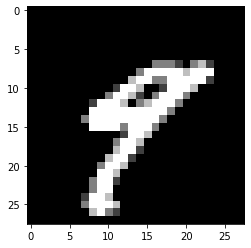

In [17]:
X_t =  X_train.values.reshape(-1,28,28,1)
g = plt.imshow(X_t[0][:, :, 0], 'gray')

In [18]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(y_train)

Y_train = encoder.transform(y_train).toarray()
y_labels = [x[3:] for x in  encoder.get_feature_names()]

# encoder.fit(y_test)
# Y_test = encoder.transform(y_test).toarray()

0 iteration: 98.68221827117341
100 iteration: 16.755615068625797
200 iteration: 14.816102445063004
300 iteration: 13.949435247165573
400 iteration: 13.422699913385511


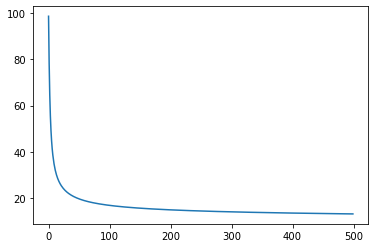

13.058806647935304
Wall time: 48.3 s


In [19]:
%%time
lg = LogisticRegression(normalize=False)
lg.fit(normalize(X_train), Y_train, 0.5, 500, 1e-15)

plot_J(lg.get_cost_history())
print(lg.get_cost_history()[-1])

In [20]:
y_pred = lg.predict(normalize(X_test))
y_pred

array([4, 0, 4, ..., 5, 0, 4])

In [21]:
# n = len(y_labels)

In [22]:
# X_test_norm = (X_test - lg.get_mean()) / lg.get_std()

# num = 0
# den = 0
# iter_res_dict = {}
# y = np.zeros(n)



# for i in range(10):
#     x = np.expand_dims(X_test_norm.iloc[i, :], axis=0)
#     for j in range(len(y_labels)):
#         y = np.zeros(n)
#         y[j] = 1
#         for k in range(100):
#             iters, result  = get_trick_iteration(x, y_labels, k, 0.01, goal=y, model=lg)
#             #if (iters == 10):
#             #    print(i, y)
#             if iters in iter_res_dict.keys():
#                 iter_res_dict[iters]["appearance_count"] += 1 
#                 iter_res_dict[iters]["success_count"] += result

#             else:
#                 iter_res_dict.update({iters: {"appearance_count": 1, "success_count": result} })
    
# success_rate = {}
# for key, value in iter_res_dict.items():
#     success_rate[key] = value["success_count"] / value["appearance_count"] * 100
        
# #print(num / den)
# #print(iter_res_dict)
# #print(success_rate)

# line1, = plt.plot(list(success_rate.keys()), list(success_rate.values()), linestyle='-', linewidth=1, color='blue', label='I-FGSM')
# plt.legend(loc="upper right")


In [219]:
from matplotlib import rc
def show_adversarial_sample(x, y_labels, true_class=[], model=None, attack_model=None, max_norm=10, max_iters=10):

    x_normalized = normalize(x)
    attack = attack_model()

    if type(attack).__name__ in ['AttackNoise']:
        x_adv_normalized = attack.attack(x_normalized, true_class, model.predict, max_norm=max_norm)
    
    elif type(attack).__name__ in ['AttackIFGSM', 'AttackTIFGSM', 'AttackFGSM', 'AttackDeepFool', 'AttackMIFGSM']:
        x_adv_normalized = attack.attack(x_normalized, model.W, model.b, true_class, model.predict, max_norm=max_norm)
        
    x_adv = denormalize(x_adv_normalized)
    x_adv_pred = model.predict(np.array(x_adv_normalized))
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, squeeze=True, sharex=True, sharey=True)
    fig.set_size_inches(15,5)
    fig.suptitle('Adversarial example')
    
    ax1.imshow(x.reshape(28,28), 'gray')
    ax1.set_title(f"Original\n prediction: {model.predict(x_normalized)[0]}")
    
    ax2.imshow(x.reshape(28,28) - x_adv.reshape(28,28), "gray")
    ax2.set_title(f"Difference")
    
    ax3.imshow(x_adv.reshape(28,28), 'gray')
    ax3.set_title(f"Adversarial\n prediction: {x_adv_pred[0]}")
    plt.show()

    pred_with_labels = model.predict_by_labels(np.array(x_adv_normalized), y_labels)
    plt.bar(pred_with_labels[0].keys(), pred_with_labels[0].values())
    plt.show()
    
    print(f"Norm_inf: {LA.norm(abs(x_normalized - x_adv_normalized), np.inf)}; Result: {attack.tricked}")
    print(f"Max value: {max(max(x_adv))}")
    print(f"Min value: {min(min(x_adv))}")

In [246]:
def untargeted_attack_benchmark(X, y_labels, model=None, attack_model=None, samples=100):
    X_norm = normalize(X)
    iter_res_dict = {}

    norms_range = np.linspace(0, 0.5, num=50)
    print(f"Perturbations list: {norms_range}")

    for i in range(samples):
        x_normalized = np.expand_dims(X_norm.iloc[i, :], axis=0)
        y = np.zeros(len(y_labels))
        true_class_pos = model.predict(x_normalized)
        y[true_class_pos] = 1
    
        for norm in norms_range:
            attack = attack_model()
            if type(attack).__name__ in ['AttackNoise']:
                a = attack.attack(x_normalized, y, model.predict, max_norm=norm)
            elif type(attack).__name__ in ['AttackIFGSM', 'AttackTIFGSM', 'AttackDeepFool', 'AttackFGSM', 'AttackMIFGSM']:
                a = attack.attack(x_normalized, model.W, model.b, y, model.predict, max_norm=norm)
                
            success = attack.tricked
            #perturbation = LA.norm(abs(a - x_normalized), np.inf)
            
            if norm in iter_res_dict.keys():
                iter_res_dict[norm]["appearance_count"] += 1
                iter_res_dict[norm]["success_count"] += success
            else:
                iter_res_dict.update({norm: {"appearance_count": 1, "success_count": success} })

    success_rate = {}
    for key, value in iter_res_dict.items():
        success_rate[key] = value["success_count"] / value["appearance_count"] * 100

    perturbations_list = [x[0] for x in sorted(success_rate.items(), key=lambda x: x[0]) ]
    successrate_list = [x[1] for x in sorted(success_rate.items(), key=lambda x: x[0]) ]

    plt.plot(perturbations_list, successrate_list)    
    return perturbations_list, successrate_list

In [25]:
correct_pred_idx = np.array(y_test.iloc[:, 0]) == y_pred

### Targeted FGSM Benchmark

Perturbations list: [0.         0.01020408 0.02040816 0.03061224 0.04081633 0.05102041
 0.06122449 0.07142857 0.08163265 0.09183673 0.10204082 0.1122449
 0.12244898 0.13265306 0.14285714 0.15306122 0.16326531 0.17346939
 0.18367347 0.19387755 0.20408163 0.21428571 0.2244898  0.23469388
 0.24489796 0.25510204 0.26530612 0.2755102  0.28571429 0.29591837
 0.30612245 0.31632653 0.32653061 0.33673469 0.34693878 0.35714286
 0.36734694 0.37755102 0.3877551  0.39795918 0.40816327 0.41836735
 0.42857143 0.43877551 0.44897959 0.45918367 0.46938776 0.47959184
 0.48979592 0.5       ]


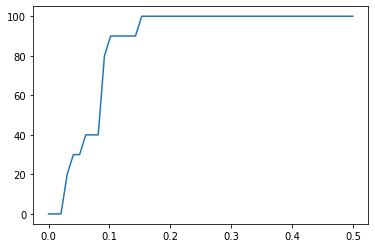

In [247]:
x1, y1 = untargeted_attack_benchmark(X_test[correct_pred_idx], y_labels, model=lg, attack_model=AttackIFGSM, samples=10)

Perturbations list: [0.         0.01020408 0.02040816 0.03061224 0.04081633 0.05102041
 0.06122449 0.07142857 0.08163265 0.09183673 0.10204082 0.1122449
 0.12244898 0.13265306 0.14285714 0.15306122 0.16326531 0.17346939
 0.18367347 0.19387755 0.20408163 0.21428571 0.2244898  0.23469388
 0.24489796 0.25510204 0.26530612 0.2755102  0.28571429 0.29591837
 0.30612245 0.31632653 0.32653061 0.33673469 0.34693878 0.35714286
 0.36734694 0.37755102 0.3877551  0.39795918 0.40816327 0.41836735
 0.42857143 0.43877551 0.44897959 0.45918367 0.46938776 0.47959184
 0.48979592 0.5       ]
[0.0, 0.01020408163265306, 0.02040816326530612, 0.030612244897959183, 0.04081632653061224, 0.0510204081632653, 0.061224489795918366, 0.07142857142857142, 0.08163265306122448, 0.09183673469387754, 0.1020408163265306, 0.11224489795918366, 0.12244897959183673, 0.13265306122448978, 0.14285714285714285, 0.1530612244897959, 0.16326530612244897, 0.17346938775510204, 0.18367346938775508, 0.19387755102040816, 0.204081632653061

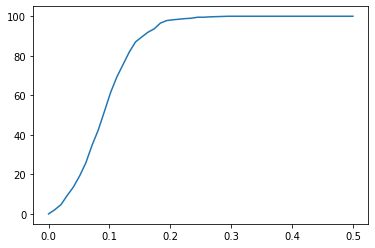

In [133]:
x2, y2 = untargeted_attack_benchmark(X_test[correct_pred_idx], y_labels, model=lg, attack_model=AttackFGSM, samples=1000)


Perturbations list: [0.         0.01020408 0.02040816 0.03061224 0.04081633 0.05102041
 0.06122449 0.07142857 0.08163265 0.09183673 0.10204082 0.1122449
 0.12244898 0.13265306 0.14285714 0.15306122 0.16326531 0.17346939
 0.18367347 0.19387755 0.20408163 0.21428571 0.2244898  0.23469388
 0.24489796 0.25510204 0.26530612 0.2755102  0.28571429 0.29591837
 0.30612245 0.31632653 0.32653061 0.33673469 0.34693878 0.35714286
 0.36734694 0.37755102 0.3877551  0.39795918 0.40816327 0.41836735
 0.42857143 0.43877551 0.44897959 0.45918367 0.46938776 0.47959184
 0.48979592 0.5       ]
[0.0, 0.01020408163265306, 0.02040816326530612, 0.030612244897959183, 0.04081632653061224, 0.0510204081632653, 0.061224489795918366, 0.07142857142857142, 0.08163265306122448, 0.09183673469387754, 0.1020408163265306, 0.11224489795918366, 0.12244897959183673, 0.13265306122448978, 0.14285714285714285, 0.1530612244897959, 0.16326530612244897, 0.17346938775510204, 0.18367346938775508, 0.19387755102040816, 0.204081632653061

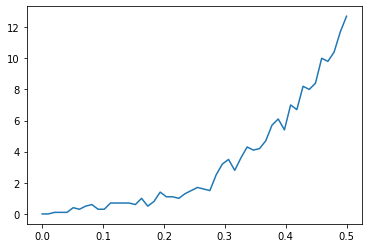

In [134]:
x3, y3 = untargeted_attack_benchmark(X_test[correct_pred_idx], y_labels, model=lg, attack_model=AttackNoise, samples=1000)

Perturbations list: [0.         0.01020408 0.02040816 0.03061224 0.04081633 0.05102041
 0.06122449 0.07142857 0.08163265 0.09183673 0.10204082 0.1122449
 0.12244898 0.13265306 0.14285714 0.15306122 0.16326531 0.17346939
 0.18367347 0.19387755 0.20408163 0.21428571 0.2244898  0.23469388
 0.24489796 0.25510204 0.26530612 0.2755102  0.28571429 0.29591837
 0.30612245 0.31632653 0.32653061 0.33673469 0.34693878 0.35714286
 0.36734694 0.37755102 0.3877551  0.39795918 0.40816327 0.41836735
 0.42857143 0.43877551 0.44897959 0.45918367 0.46938776 0.47959184
 0.48979592 0.5       ]
[0.0, 0.01020408163265306, 0.02040816326530612, 0.030612244897959183, 0.04081632653061224, 0.0510204081632653, 0.061224489795918366, 0.07142857142857142, 0.08163265306122448, 0.09183673469387754, 0.1020408163265306, 0.11224489795918366, 0.12244897959183673, 0.13265306122448978, 0.14285714285714285, 0.1530612244897959, 0.16326530612244897, 0.17346938775510204, 0.18367346938775508, 0.19387755102040816, 0.204081632653061

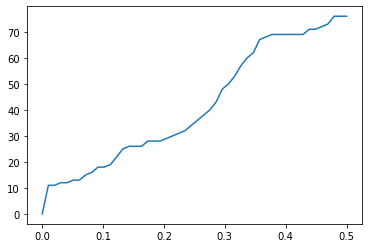

In [194]:
x4, y4 = untargeted_attack_benchmark(X_test[correct_pred_idx], y_labels, model=lg, attack_model=AttackDeepFool, samples=100)

Perturbations list: [0.         0.01020408 0.02040816 0.03061224 0.04081633 0.05102041
 0.06122449 0.07142857 0.08163265 0.09183673 0.10204082 0.1122449
 0.12244898 0.13265306 0.14285714 0.15306122 0.16326531 0.17346939
 0.18367347 0.19387755 0.20408163 0.21428571 0.2244898  0.23469388
 0.24489796 0.25510204 0.26530612 0.2755102  0.28571429 0.29591837
 0.30612245 0.31632653 0.32653061 0.33673469 0.34693878 0.35714286
 0.36734694 0.37755102 0.3877551  0.39795918 0.40816327 0.41836735
 0.42857143 0.43877551 0.44897959 0.45918367 0.46938776 0.47959184
 0.48979592 0.5       ]
[0.0, 0.01020408163265306, 0.02040816326530612, 0.030612244897959183, 0.04081632653061224, 0.0510204081632653, 0.061224489795918366, 0.07142857142857142, 0.08163265306122448, 0.09183673469387754, 0.1020408163265306, 0.11224489795918366, 0.12244897959183673, 0.13265306122448978, 0.14285714285714285, 0.1530612244897959, 0.16326530612244897, 0.17346938775510204, 0.18367346938775508, 0.19387755102040816, 0.204081632653061

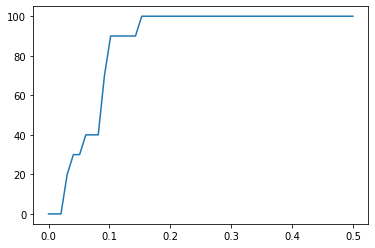

In [240]:
x5, y5 = untargeted_attack_benchmark(X_test[correct_pred_idx], y_labels, model=lg, attack_model=AttackMIFGSM, samples=10)

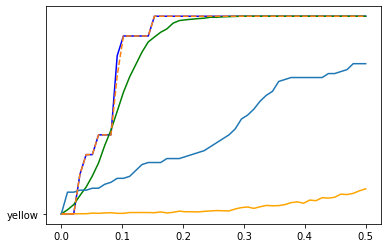

In [245]:
plt.plot(np.array(x1), y1, 'b')
plt.plot(np.array(x2), y2, 'g')
plt.plot(np.array(x3), y3, 'orange')
plt.plot(np.array(x4), y4, '')
plt.plot(np.array(x5), y5, '--', 'yellow')

### Untargeted Noise Attack

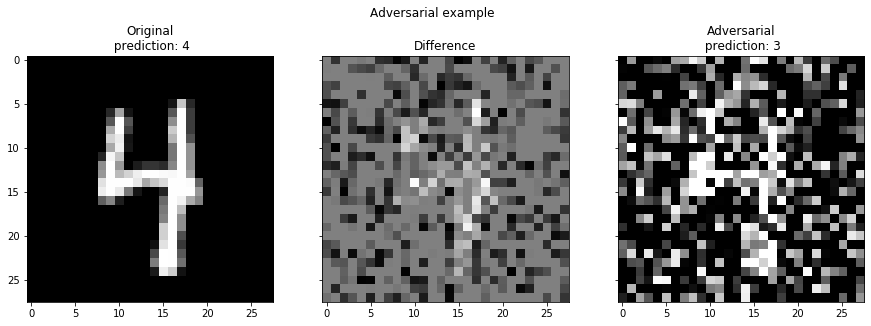

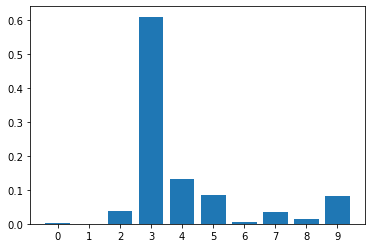

Perturbation: 190.83959179208824; Result: True
Max value: 255.0
Min value: 0.0
Max perturbation: 254.0


In [202]:
index = 38
x = np.expand_dims(X_test.iloc[index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackNoise, max_norm=1)

### Untargeted FGSM

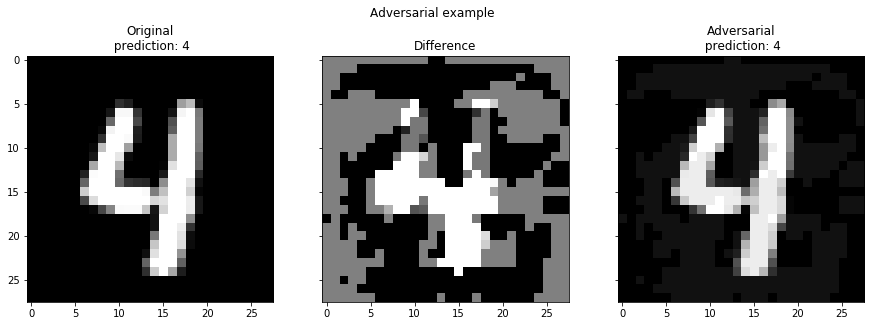

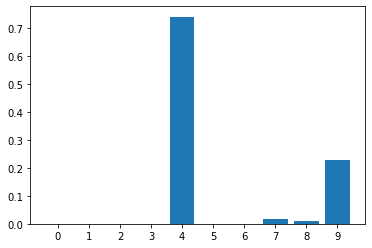

Perturbation: 32.08823529411765; Result: False
Max value: 255.0
Min value: 0.0
Max perturbation: 17.850000000000023


In [203]:
index = 0
x = np.expand_dims(X_test.iloc[index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackFGSM, max_norm=0.07)

### Untargeted I-FGSM

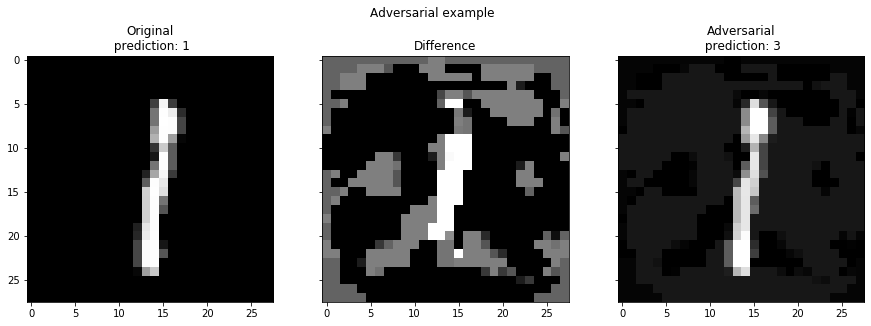

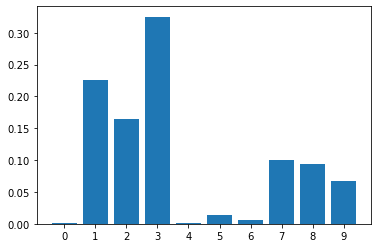

Perturbation: 48.89745098039215; Result: True
Max value: 255.0
Min value: 0.0
Max perturbation: 22.950000000000045


In [204]:
index = 422
x = np.expand_dims(X_test.iloc[index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackIFGSM, max_norm=1, max_iters=100)

### DeepFool

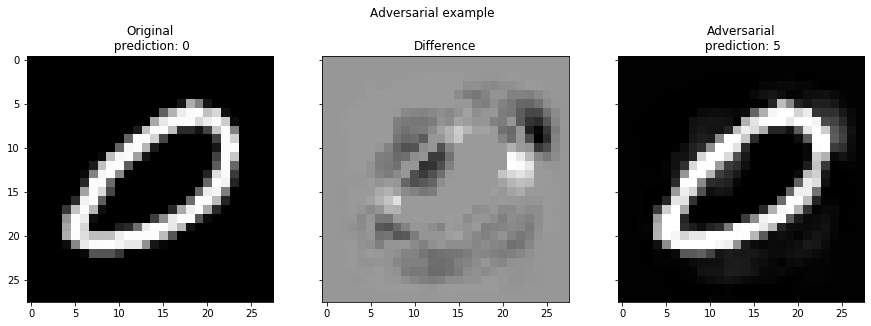

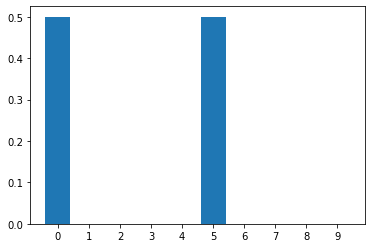

Perturbation: 24.071168055154843; Result: True
Max value: 255.0
Min value: 0.0
Max perturbation: 61.25438372748749


In [233]:
index = 1
x = np.expand_dims(X_test.iloc[index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackDeepFool, max_norm=100, max_iters=100)

### Targeted I-FGSM

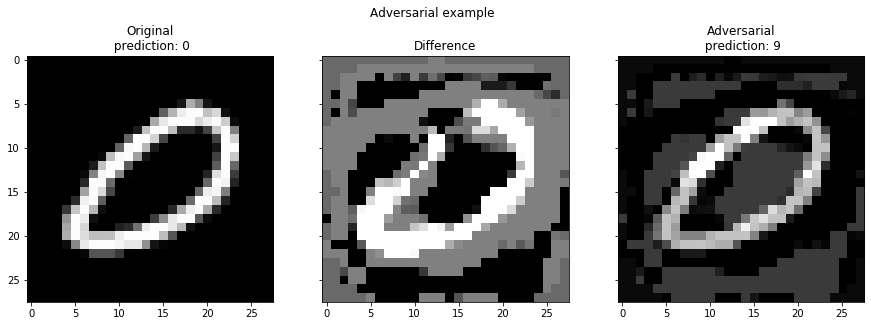

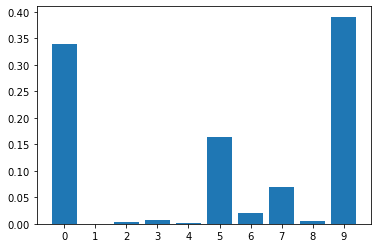

Perturbation: 87.32627450980398; Result: True
Max value: 255.0
Min value: 0.0
Max perturbation: 58.65000000000006


In [210]:
index = 1
x = np.expand_dims(X_test.iloc[index, :], axis=0)
y = np.zeros(len(y_labels))
y[9] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackTIFGSM, max_norm=0.5, max_iters=100)

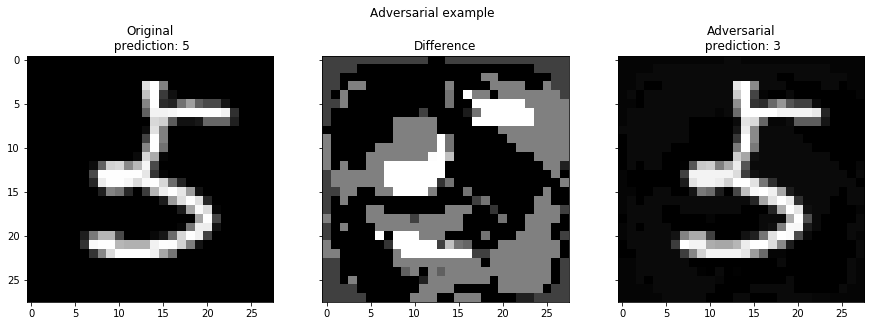

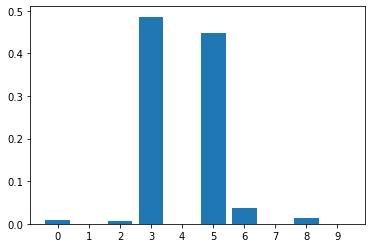

Perturbation: 19.252156862745103; Result: True
Max value: 255.0
Min value: 0.0
Max perturbation: 10.200000000000017


In [230]:
index = 123
x = np.expand_dims(X_test.iloc[index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackMIFGSM, max_norm=1, max_iters=100)

In [ ]:
y_real = np.array(y_test.iloc[:, 0])

comp = pd.DataFrame({"y_pred": y_pred, "y_real": y_real})
print(comp.head(20))

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
rmse = mean_squared_error(y_real, y_pred, squared=True)
mse = mean_squared_error(y_real, y_pred, squared=False)
mae = mean_absolute_error(y_real, y_pred)
r2 = r2_score(y_real, y_pred)
accuracy = int(sum(y_real == y_pred) / len(y_pred) * 100)


#print(f'Coefficients\n {theta}')
print(f'Root mean squared error: {rmse}')
print(f'Mean squared error: {mse}')
print(f'Mean absolute error: {mae}')
print(f'Coefficient of determination: {r2}')
print(f"Accuracy: {accuracy}%")

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt


# # Example data
# t = np.arange(0.0, 1.0 + 0.01, 0.01)
# s = np.cos(4 * np.pi * t) + 2

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# plt.plot(t, s)

# plt.xlabel(r'\textbf{time} (s)')
# plt.ylabel(r'\textit{voltage} (mV)',fontsize=16)
# plt.title(r"\TeX\ is Number "
#           r"$\displaystyle\sum_{n=1}^\infty\frac{-e^{i\pi}}{2^n}$!",
#           fontsize=16, color='gray')
# # Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)

# # plt.savefig('tex_demo')
# # plt.show()